# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Project 3: Web APIs & NLP

--- 

*Group 3* | *Team Members: Constance, Wenzhe, Matthew, Joel*

### <b> Notebook 4: Classification Analyses </b>

<b>(a) Overview of Notebook 4 </b>

In part 1, we will perform lemmatization on our corpus, removal of unncessary characters as well as stop words, making use of lemmatizers as well as vectorizers. For vectorizers we will use both Count Vectorizer and the TF-IDF Vectorizer.


In part 2, we will be using the 4 modelling algorithms for classification analyses:
1. Naive Bayes with Count Vectorizer
2. Naive Bayes with TD-IDF Vectorizer
3. Random Forest with Count Vectorizer
4. Random Forest with TD-IDF Vectorizer
5. Gradient Boosting

For each modelling algorithm, we will run the following matrices and a classification report to see how well it did for classification:
- Accuracy 
- Specificity
- Recall
- Precision
- F1-score

<br>

<b>(b) Structure of Notebook 4</b>

* Part 1: Preprocessing the Corpus
    - Adding labels to respective subreddit comments
    - Lemmatization and Removal of Unnecessary Characters
    - Word Vectorization (includes removal of stop words)
* Part 2: Modelling
    - Naive Bayes with Count Vectorizer
    - Naive Bayes with TD-IDF Vectorizer
    - Random Forest with Count Vectorizer
    - Random Forest with TD-IDF Vectorizer
    - Gradient Boosting with Count Vectorizer
* Part 3: Choosing our Model & Deployment onto Streamlit
    - Save chosen model into a .pkl file
    - Save chosen vectorizer into a .pkl file


---

### Import Libraries & Read Cleaned Data

In [1]:
# Standard imports
import numpy as np
import pandas as pd


# Preprocessing imports
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


# Modelling imports
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  recall_score, precision_score, f1_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
# Read cleaned coffee and tea datasets
df_coffee = pd.read_csv("data/coffee_comments_clean_merged_filtered.csv")
df_tea    = pd.read_csv("data/tea_comments_clean_merged_filtered.csv")

In [3]:
df_coffee.head(2)

,thread_id,comment_id,comment_text,comment_score,author_name,id,title,score,num_comments,post_hint,self_text,author_name_thread,url,url_is_media,comment_score_top_or_bottom_4
0,19agk2c,kikp8lv,Hi! I’m a morning coffee drinker but I never m...,2,testingpage2025,19agk2c,[MOD] The Daily Question Thread,2,58,NaN,\n\nWelcome to the daily [/r/Coffee](https://...,menschmaschine5,https://www.reddit.com/r/Coffee/comments/19agk...,0,1
1,19agk2c,kikxhmz,Any Scooters employees around? I need to know ...,2,Ok_Bet_2634,19agk2c,[MOD] The Daily Question Thread,2,58,NaN,\n\nWelcome to the daily [/r/Coffee](https://...,menschmaschine5,https://www.reddit.com/r/Coffee/comments/19agk...,0,1


In [4]:
df_tea.head(2)

,thread_id,comment_id,comment_text,comment_score,author_name,id,title,score,num_comments,post_hint,self_text,author_name_thread,url,url_is_media,comment_score_top_or_bottom_4
0,199pmki,kifj4sk,"After a rough few days here in Oregon, the mor...",8,oldhippy1947,199pmki,"What's in your cup? Daily discussion, question...",5,18,NaN,What are you drinking today? What questions ha...,AutoModerator,https://www.reddit.com/r/tea/comments/199pmki/...,0,1
1,199pmki,kifik9x,Finishing the last of my Kabusecha from hibiki...,6,42AMSW,199pmki,"What's in your cup? Daily discussion, question...",5,18,NaN,What are you drinking today? What questions ha...,AutoModerator,https://www.reddit.com/r/tea/comments/199pmki/...,0,1


### Part 1: Preprocessing the corpus
<br>
<b>(a) Adding labels to identify coffee or tea comments </b>

In [5]:
# Add "coffee/tea" subreddit identifer
df_coffee["subreddit_coffee"] = 1
df_tea["subreddit_coffee"] = 0 

# Append to one common dataframe, df_coffee_tea
df_coffee_tea = pd.concat(objs = [df_coffee, df_tea], axis=0)
df_coffee_tea.reset_index(drop = True, inplace = True)
df_coffee_tea.head(1)

,thread_id,comment_id,comment_text,comment_score,author_name,id,title,score,num_comments,post_hint,self_text,author_name_thread,url,url_is_media,comment_score_top_or_bottom_4,subreddit_coffee
0,19agk2c,kikp8lv,Hi! I’m a morning coffee drinker but I never m...,2,testingpage2025,19agk2c,[MOD] The Daily Question Thread,2,58,NaN,\n\nWelcome to the daily [/r/Coffee](https://...,menschmaschine5,https://www.reddit.com/r/Coffee/comments/19agk...,0,1,1


<b>(b) Lemmatizing and removal of unncessary characters using a function</b>

In [6]:
# Instantiate stopwords and lemmatizer
stop_words = list(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Define a function to process our sentences 
def process_sentences(sentence):

    # 1. Tokenize sentence 
    # a. only retain pre-apostrophe portion of words (e.g., "we" from "we'll"))
    sentence = " " + str(sentence)
    sentence = sentence.lower()

    tokenizer_regex = RegexpTokenizer("\s[\w]+")
    sentence_tokens_initial = tokenizer_regex.tokenize(sentence)
    sentence_tokens_revised = [token.strip() for token in sentence_tokens_initial]    

    # 2. Remove tokens that are stop words
    for stop_word in stop_words:
        while stop_word in sentence_tokens_revised:
            sentence_tokens_revised.remove(stop_word)

    # 3. Lemmatize tokens
    sentence_tokens_revised = [lemmatizer.lemmatize(token) for token in sentence_tokens_revised]

    # 4. Rebuild sentence based on processed tokens
    sentence_processed = " ".join(sentence_tokens_revised)

    return sentence_processed

In [7]:
# Invoke function on our dataframe
# Add a new column to show the processed text
df_coffee_tea["comment_text_processed"] = df_coffee_tea["comment_text"].apply(process_sentences)
df_coffee_tea[["comment_text", "comment_text_processed"]].head(3)

,comment_text,comment_text_processed
0,Hi! I’m a morning coffee drinker but I never m...,hi morning coffee drinker never make home one ...
1,Any Scooters employees around? I need to know ...,scooter employee around need know buy ice crea...
2,I can't find a pumpkin spice latte recipe that...,find pumpkin spice latte recipe pumpkin spice ...


<b>(c) Word Vectorization </b>

We will be using Count Vectorizer and TFIDF Vectorizer. 

For both vectorizers, they have inbuild hyperparameters to:

1. lower case our individual words: lowercase
2. remove stop words: stop_words = "english"
3. perform n_grams - we will do (1,2) n-grams: ngram_range
4. ignore words that are below the minimum frequency in our corpus: min_df
5. set a maxminum number of features we want: max_features

In [8]:
df_coffee_tea.head(2)

,thread_id,comment_id,comment_text,comment_score,author_name,id,title,score,num_comments,post_hint,self_text,author_name_thread,url,url_is_media,comment_score_top_or_bottom_4,subreddit_coffee,comment_text_processed
0,19agk2c,kikp8lv,Hi! I’m a morning coffee drinker but I never m...,2,testingpage2025,19agk2c,[MOD] The Daily Question Thread,2,58,NaN,\n\nWelcome to the daily [/r/Coffee](https://...,menschmaschine5,https://www.reddit.com/r/Coffee/comments/19agk...,0,1,1,hi morning coffee drinker never make home one ...
1,19agk2c,kikxhmz,Any Scooters employees around? I need to know ...,2,Ok_Bet_2634,19agk2c,[MOD] The Daily Question Thread,2,58,NaN,\n\nWelcome to the daily [/r/Coffee](https://...,menschmaschine5,https://www.reddit.com/r/Coffee/comments/19agk...,0,1,1,scooter employee around need know buy ice crea...


In [9]:
# Define X and y variables
X = df_coffee_tea["comment_text_processed"] 
y = df_coffee_tea["subreddit_coffee"]

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state = 42)

_Count Vectorizer (with top-30-word plot included) on Trained Data_

<Axes: >

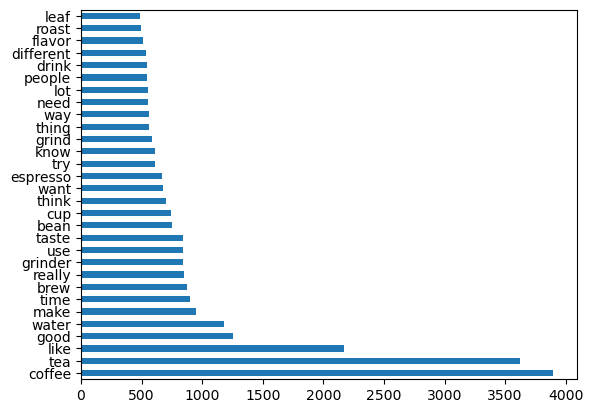

In [10]:
# Instantiate CountVectorizer
cvec = CountVectorizer(lowercase = True, stop_words = "english", ngram_range = (1,2), max_features = 250, min_df = 5)

# Fit the vectorizer on our X_train corpus, and transform the corpus
X_train_cvec = cvec.fit_transform(X_train)

# Convert training data to dataframe
X_train_cvec_df = pd.DataFrame(X_train_cvec.todense(), columns = cvec.get_feature_names_out())

# Plot top 20 occuring words
X_train_cvec_df.sum().sort_values(ascending = False).head(30).plot(kind = "barh")

_Count Vectorizer (with top-30-word plot included) on Test Data_

<Axes: >

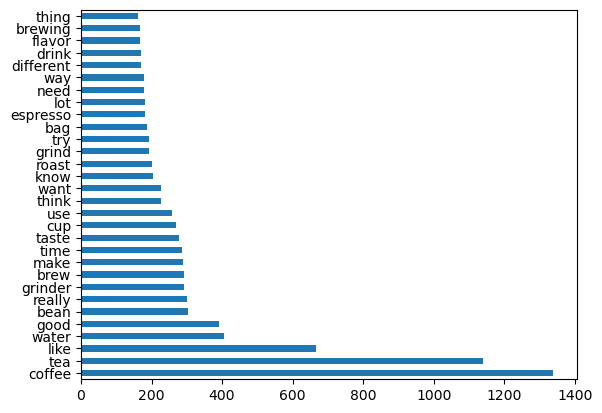

In [11]:
# Transform the X_test corpus
X_test_cvec = cvec.transform(X_test)

# Convert training data to dataframe
X_test_cvec_df = pd.DataFrame(X_test_cvec.todense(), columns = cvec.get_feature_names_out())

# Plot top 20 occuring words
X_test_cvec_df.sum().sort_values(ascending = False).head(30).plot(kind = "barh")

_TD-IDF Vectorizer (with top-30-word plot included) on Trained Data_

<Axes: >

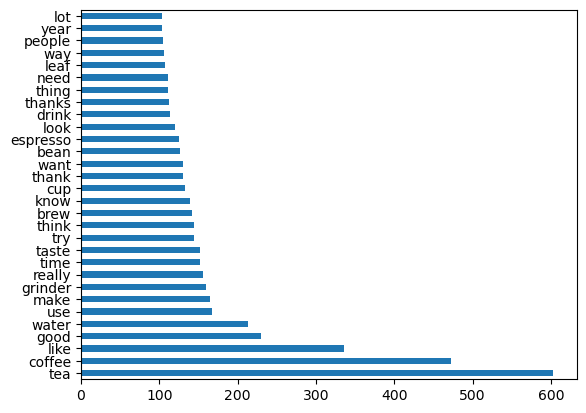

In [12]:
# Instantiate TF-IDF Vectorizer
tvec = TfidfVectorizer(lowercase = True, stop_words = "english", ngram_range = (1,2), max_features = 250, min_df = 5)

# Fit the vectorizer on our X_train corpus, and transform the corpus
X_train_tvec = tvec.fit_transform(X_train)

# Convert training data to dataframe
X_train_tvec_df = pd.DataFrame(X_train_tvec.todense(), columns = tvec.get_feature_names_out())

# Plot top 20 occuring words
X_train_tvec_df.sum().sort_values(ascending = False).head(30).plot(kind = "barh")

_TD-IDF Vectorizer (with top-30-word plot included) on Test Data_

<Axes: >

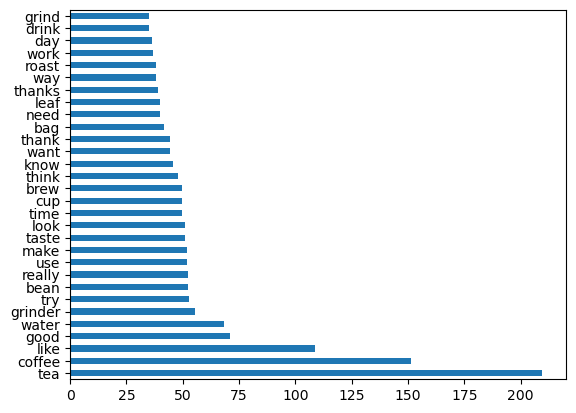

In [13]:
# Fit the vectorizer on our X_test corpus, and transform the corpus
X_test_tvec = tvec.fit_transform(X_test)

# Convert training data to dataframe
X_test_tvec_df = pd.DataFrame(X_test_tvec.todense(), columns = tvec.get_feature_names_out())

# Plot top 20 occuring words
X_test_tvec_df.sum().sort_values(ascending = False).head(30).plot(kind = "barh")

### Part 2: Modelling

##### <b>1. Multinomial Naive Bayes with Count Vectorizer</b>

In [14]:
# Instantiate the naive bayes model
nb = MultinomialNB()

# Fit the model
model_cvec = nb.fit(X_train_cvec, y_train)

# Get predictions
predictions_cvec = model_cvec.predict(X_test_cvec)

In [15]:
# r2 score (accuracy score) on train corpus
model_cvec.score(X_train_cvec, y_train)

0.8587721768515911

In [16]:
# r2 score (accuracy score) on test corpus
model_cvec.score(X_test_cvec, y_test)

0.8581081081081081

In [17]:
# Generate the confusion matrix for model_cvec
confusion_matrix(y_test, predictions_cvec)

# Fix the order of tn, fp, fn, tp
tn, fp, fn, tp = confusion_matrix(y_test, predictions_cvec).ravel()

# Print the respective results
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 1058
False Positives: 135
False Negatives: 201
True Positives: 974


In [18]:
# Calculate the specificity, recall, precision and f1-scores for model_cvec
specificity = tn / (tn + fp)
recall = recall_score(y_test, predictions_cvec)
precision = precision_score(y_test, predictions_cvec)
harmonic_mean = f1_score(y_test, predictions_cvec)

# Print the scores out
print("Specificity: %s" % specificity)
print("Recall: %s" % recall)
print("Precision: %s" % precision)
print("F1 Score: %s" % harmonic_mean)

Specificity: 0.8868398994132439
Recall: 0.828936170212766
Precision: 0.8782687105500451
F1 Score: 0.8528896672504378


In [19]:
# Classification report for Naive Bayes (Count Vectorizer)
print(classification_report(y_test, predictions_cvec))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1193
           1       0.88      0.83      0.85      1175

    accuracy                           0.86      2368
   macro avg       0.86      0.86      0.86      2368
weighted avg       0.86      0.86      0.86      2368



##### <b>2. Multinomial Naive Bayes with TD-IDF Vectorizer</b>

In [20]:
# Fit the model
model_tvec = nb.fit(X_train_tvec, y_train)

# Get predictions
predictions_tvec = model_tvec.predict(X_test_tvec)

In [21]:
# r2 score (accuracy score) on train corpus
model_tvec.score(X_train_tvec, y_train)

0.8590537876654464

In [22]:
# r2 score (accuracy score) on test corpus
model_tvec.score(X_test_tvec, y_test)

0.7111486486486487

In [23]:
# Generate the confusion matrix for model_tvec
confusion_matrix(y_test, predictions_tvec)

# Fix the order of tn, fp, fn, tp
tn, fp, fn, tp = confusion_matrix(y_test, predictions_tvec).ravel()

# Print the respective results
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 794
False Positives: 399
False Negatives: 285
True Positives: 890


In [24]:
# Calculate the specificity, recall, precision and f1-scores for model_tvec
specificity = tn / (tn + fp)
recall = recall_score(y_test, predictions_tvec)
precision = precision_score(y_test, predictions_tvec)
harmonic_mean = f1_score(y_test, predictions_tvec)

# Print the scores out
print("Specificity: %s" % specificity)
print("Recall: %s" % recall)
print("Precision: %s" % precision)
print("F1 Score: %s" % harmonic_mean)

Specificity: 0.6655490360435876
Recall: 0.7574468085106383
Precision: 0.6904577191621412
F1 Score: 0.7224025974025974


In [25]:
# Classification report for Naive Bayes (TD-IDF Vectorizer)
print(classification_report(y_test, predictions_tvec))

              precision    recall  f1-score   support

           0       0.74      0.67      0.70      1193
           1       0.69      0.76      0.72      1175

    accuracy                           0.71      2368
   macro avg       0.71      0.71      0.71      2368
weighted avg       0.71      0.71      0.71      2368



##### <b>3. Random Forest with Count Vectorizer</b>

In [26]:
# Instantiate the random forest model
rf = RandomForestClassifier()

In [27]:
# Use GridSearch to provide us with optimal parameters for random forest with Count Vectorizer

# Define the parameters that we want to test
rf_params = {
    "n_estimators": [100, 150, 200],
    "max_depth": [2, 3, 5, 7],
    "min_samples_split": [10, 15, 20],
    "min_samples_leaf": [3, 4, 5, 7]
    }

# Use GridSearch to give us the best parameters 
rf_gs = GridSearchCV(rf, param_grid = rf_params, cv = 5)

# Fit GridSearch model onto X_train_cvec
rf_gs.fit(X_train_cvec, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 3, 5, 7],
                         'min_samples_leaf': [3, 4, 5, 7],
                         'min_samples_split': [10, 15, 20],
                         'n_estimators': [100, 150, 200]})

In [28]:
# Get the best parameters and best score
best_score_cvec = rf_gs.best_score_
best_parameters_cvec = rf_gs.best_params_

print("Best Score for cvec: %s" % best_score_cvec)
print("Best Parameters for cvec: %s" % best_parameters_cvec)

Best Score for cvec: 0.8435657293514783
Best Parameters for cvec: {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 15, 'n_estimators': 100}


In [29]:
# r2 score (accuracy score) on train corpus
rf_gs.score(X_train_cvec, y_train)

0.8380737820332301

In [30]:
# r2 score (accuracy score) on test corpus
rf_gs.score(X_test_cvec, y_test)

0.8336148648648649

In [31]:
# Get predictions
gs_predictions_cvec = rf_gs.predict(X_test_cvec)

In [32]:
# Generate the confusion matrix for random forest with cvec
confusion_matrix(y_test, gs_predictions_cvec)

# Fix the order of tn, fp, fn, tp
tn, fp, fn, tp = confusion_matrix(y_test, gs_predictions_cvec).ravel()

# Print the respective results
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 1174
False Positives: 19
False Negatives: 375
True Positives: 800


In [33]:
# Calculate the specificity, recall, precision and f1-scores for random forest with cvec
specificity = tn / (tn + fp)
recall = recall_score(y_test, gs_predictions_cvec)
precision = precision_score(y_test, gs_predictions_cvec)
harmonic_mean = f1_score(y_test, gs_predictions_cvec)

# Print the scores out
print("Specificity: %s" % specificity)
print("Recall: %s" % recall)
print("Precision: %s" % precision)
print("F1 Score: %s" % harmonic_mean)

Specificity: 0.9840737636211232
Recall: 0.6808510638297872
Precision: 0.9768009768009768
F1 Score: 0.8024072216649949


In [34]:
# Classification report for random forest (Count Vectorizer)
print(classification_report(y_test, gs_predictions_cvec))

              precision    recall  f1-score   support

           0       0.76      0.98      0.86      1193
           1       0.98      0.68      0.80      1175

    accuracy                           0.83      2368
   macro avg       0.87      0.83      0.83      2368
weighted avg       0.87      0.83      0.83      2368



##### <b>4. Random Forest with TD-IDF Vectorizer</b>

In [35]:
# Use GridSearch to provide us with optimal parameters for random forest with TD-IDF Vectorizer

# Define the parameters that we want to test
rf_params = {
    "n_estimators": [100, 150, 200],
    "max_depth": [2, 3, 5, 7],
    "min_samples_split": [10, 15, 20],
    "min_samples_leaf": [3, 4, 5, 7]
    }

# Use GridSearch to give us the best parameters 
rf_gs_tvec = GridSearchCV(rf, param_grid = rf_params, cv = 5)

# Fit GridSearch model onto X_train_tvec
rf_gs_tvec.fit(X_train_tvec, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 3, 5, 7],
                         'min_samples_leaf': [3, 4, 5, 7],
                         'min_samples_split': [10, 15, 20],
                         'n_estimators': [100, 150, 200]})

In [36]:
# Get the best parameters and best score
best_score_tvec = rf_gs_tvec.best_score_
best_parameters_tvec = rf_gs_tvec.best_params_

print("Best Score for tvec: %s" % best_score_tvec)
print("Best Parameters for tvec: %s" % best_parameters_tvec)

Best Score for tvec: 0.8463817387081107
Best Parameters for tvec: {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


In [37]:
# r2 score (accuracy score) on train corpus
rf_gs_tvec.score(X_train_tvec, y_train)

0.8491974091805126

In [38]:
# r2 score (accuracy score) on test corpus
rf_gs_tvec.score(X_test_tvec, y_test)

0.6883445945945946

In [39]:
# Get predictions
gs_predictions_tvec = rf_gs_tvec.predict(X_test_tvec)

In [40]:
# Generate the confusion matrix for random forest with tvec
confusion_matrix(y_test, gs_predictions_tvec)

# Fix the order of tn, fp, fn, tp
tn, fp, fn, tp = confusion_matrix(y_test, gs_predictions_tvec).ravel()

# Print the respective results
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 924
False Positives: 269
False Negatives: 469
True Positives: 706


In [41]:
# Calculate the specificity, recall, precision and f1-scores for random forest with tvec
specificity = tn / (tn + fp)
recall = recall_score(y_test, gs_predictions_tvec)
precision = precision_score(y_test, gs_predictions_tvec)
harmonic_mean = f1_score(y_test, gs_predictions_tvec)

# Print the scores out
print("Specificity: %s" % specificity)
print("Recall: %s" % recall)
print("Precision: %s" % precision)
print("F1 Score: %s" % harmonic_mean)

Specificity: 0.7745180217937971
Recall: 0.6008510638297873
Precision: 0.7241025641025641
F1 Score: 0.6567441860465116


In [42]:
# Classification report for random forest (TD-IDF Vectorizer)
print(classification_report(y_test, gs_predictions_tvec))

              precision    recall  f1-score   support

           0       0.66      0.77      0.71      1193
           1       0.72      0.60      0.66      1175

    accuracy                           0.69      2368
   macro avg       0.69      0.69      0.69      2368
weighted avg       0.69      0.69      0.69      2368



##### <b>5. Gradient Boosting with Count Vectorizer</b>

In [43]:
# Instantiate the gradient boosting classifier
gboost = GradientBoostingClassifier()

In [44]:
# Use GridSearch to provide us with optimal parameters for gradient boosting
# Intentionally keeping the hyperparameters same as random forest so that we can see if gboost makes it better or not

# Define the parameters that we want to test
gboost_params = {"n_estimators": [100, 150, 200],
                 "max_depth": [2, 3, 5, 7],
                 "min_samples_split": [10, 15, 20],
                 "min_samples_leaf": [3, 4, 5, 7]
                 }

# Use GridSearch to give us the best parameters 
gboost_gs = GridSearchCV(gboost, param_grid = gboost_params, cv = 5)

# Fit GridSearch onto X_train_cvec
gboost_gs.fit(X_train_cvec, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [2, 3, 5, 7],
                         'min_samples_leaf': [3, 4, 5, 7],
                         'min_samples_split': [10, 15, 20],
                         'n_estimators': [100, 150, 200]})

In [45]:
# Get the best parameters and best score
best_score_gboost = gboost_gs.best_score_
best_parameters_gboost = gboost_gs.best_params_

print("Best Score for gradient boost: %s" % best_score_gboost)
print("Best Parameters for gradient boost: %s" % best_parameters_gboost)

Best Score for gradient boost: 0.8603201474859008
Best Parameters for gradient boost: {'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 150}


In [46]:
# r2 score (accuracy score) on train corpus
gboost_gs.score(X_train_cvec, y_train)

0.9041115178822867

In [47]:
# r2 score (accuracy score) on test corpus
gboost_gs.score(X_test_cvec, y_test)

0.8534628378378378

In [48]:
# Get predictions
gboost_gs_predictions = rf_gs_tvec.predict(X_test_cvec)

In [49]:
# Generate the confusion matrix for gradient boosting
confusion_matrix(y_test, gboost_gs_predictions)

# Fix the order of tn, fp, fn, tp
tn, fp, fn, tp = confusion_matrix(y_test, gboost_gs_predictions).ravel()

# Print the respective results
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 1172
False Positives: 21
False Negatives: 349
True Positives: 826


In [50]:
# Calculate the specificity, recall, precision and f1-scores for gradient boosting
specificity = tn / (tn + fp)
recall = recall_score(y_test, gboost_gs_predictions)
precision = precision_score(y_test, gboost_gs_predictions)
harmonic_mean = f1_score(y_test, gboost_gs_predictions)

# Print the scores out
print("Specificity: %s" % specificity)
print("Recall: %s" % recall)
print("Precision: %s" % precision)
print("F1 Score: %s" % harmonic_mean)

Specificity: 0.9823973176865046
Recall: 0.7029787234042553
Precision: 0.9752066115702479
F1 Score: 0.8170128585558851


In [51]:
# Classification report for gradient boosting (Count Vectorizer)
print(classification_report(y_test, gboost_gs_predictions))

              precision    recall  f1-score   support

           0       0.77      0.98      0.86      1193
           1       0.98      0.70      0.82      1175

    accuracy                           0.84      2368
   macro avg       0.87      0.84      0.84      2368
weighted avg       0.87      0.84      0.84      2368



**Summary:**

We have compiled the statistics from all 5 models. The screenshot is as shown:

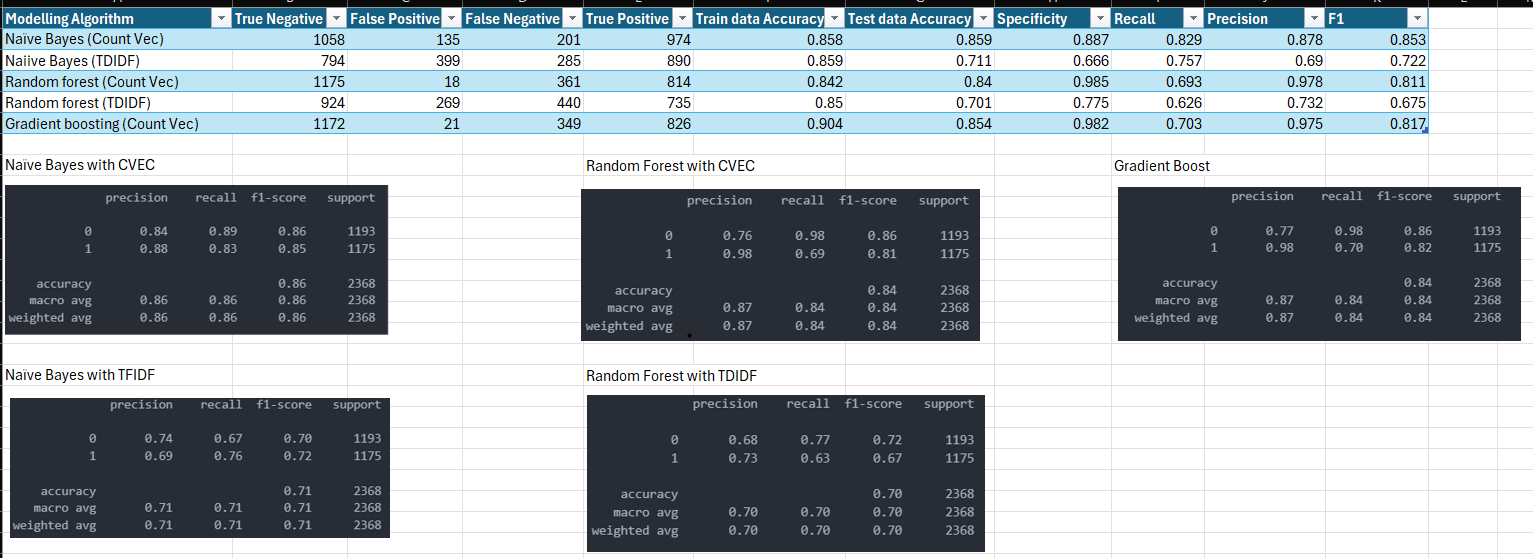

Based on all the results from the 5 models, we will go with `Naive Bayes using Count Vectorizer` as our chosen model.

Out of all the models, the accuracy score between training data and testing data is the closest to each other:
- indicated that the model trained well on the training data
- also generalized well enough onto the testing data
- Good accuracy score also meant that the model can predict the coffee and tea drinkers correctly (True Postives and True Negatives)

<br>

Wnen taking into other metric scores into consideration, we need to consider both tea and coffee predictions. Ideally, we want a model that can predict well for both instead of predicting well for only one group. To do this, at a general level, the metric scores for both 0 ("Tea) and 1 ("Coffee) (from the classification report) should not show great disparity, instead of focusing on the highest scores. In this case, Naive Bayes with Count Vectorizer did the best among all the models.

---

### Part 3: Choosing our Model & Deployment onto Streamlit

In this part, we will need to import the chosen trained model and the chosen vectorizer into .pkl files so that we can put it on the streamlit code to deploy it.
The purpose of using streamlit so that we can choose a random comment off the coffee or tea subreddit (or any social media platform) and put it into our model to predict if the user is a coffee or tea user.

In [53]:
# save our chosen model in a pkl file so we can put into streamlit
import joblib

joblib.dump(model_cvec, "./code/naive_bayes_cvec.pkl")

['./code/naive_bayes_cvec.pkl']

In [54]:
# save the count vectorizer in a pkl file so we can put into streamlit
joblib.dump(cvec, "./code/cvec.pkl")

['./code/cvec.pkl']